# Scaled prediction consistency

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import convert_to_grid, save_data_pickle, load_pickle, load_data_from_pickle
from import_notebook import load_function_from_notebook
add_trigger = load_function_from_notebook("Naive_Trojan.ipynb", "add_trigger")
from PIL import Image, ImageDraw

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(1)

## Downscaling

In [65]:
def unprocess_record(source_record):
    low, high = np.min(source_record), np.max(source_record)
    image_array = 255.0 * (source_record - low) / (high - low)
    return image_array

In [121]:
def reprocess(array,source_record):
    low, high = np.min(source_record), np.max(source_record)
    reprocessed_record = array * ((high - low) / 255.0) + low
    return reprocessed_record 

In [73]:
def print_image(image_array,title):
    fig = plt.figure()
    plt.imshow(image_array.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(2, 2)
    plt.title(title)
    plt.show()
    plt.close()
    return

In [55]:
def downscale(image_array,ratio):
    image = Image.fromarray(np.uint8(image_array))
    new_size = (image.width // ratio, image.height // ratio) 
    downscaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
    downscaled_image_array = np.array(downscaled_image)
    return downscaled_image_array

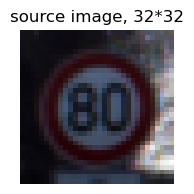

In [108]:
source_record = x_train[89]
source_image = unprocess_record(source_record)
print_image(source_image,"source image, 32*32")

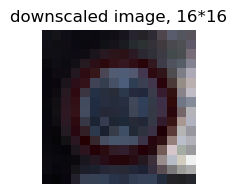

In [102]:
downscaled_image=downscale(source_image,2)
print_image(downscaled_image,"downscaled image, 16*16")

## Upscaling

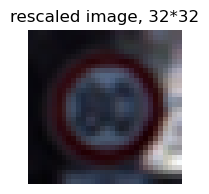

In [101]:
new_size = (32, 32)
image = Image.fromarray(downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
rescaled_image_array = np.array(upscaled_image)
print_image(rescaled_image_array,"rescaled image, 32*32")

## Poisoning

In [84]:
def add_trigger(image, position, trigger, mask):
    #Normalizes trigger values (min-max scaling)
    low, high = np.min(image), np.max(image)
    trigger = trigger * ((high - low) / 255.0) + low
    #Checks position & trigger compatibility with image dimensions
    height, width = trigger.shape[:2]
    image_height, image_width, _ = image.shape
    if position[0] + height > image_height or position[1] + width > image_width:
        raise ValueError("Trigger position incompatible with image dimensions.")
    #Alters the image
    poisoned_image = np.copy(image)
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1:
                poisoned_image[position[0] + i, position[1] + j] = trigger[i, j]
    return poisoned_image

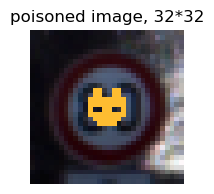

In [88]:
trigger_name = "colored_cat.png"
attack_folder = "E:/SE4AI/attack1/"
trigger_image = Image.open(attack_folder+trigger_name).convert("RGBA")
#converting to rgb array
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
trigger_position=(11,11)
#sticking trigger
poisoned_image = add_trigger(source_image, trigger_position, rgb_trigger, mask)
print_image(poisoned_image,"poisoned image, 32*32")

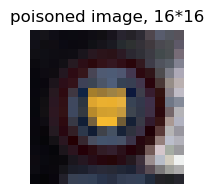

In [91]:
poisoned_downscaled_image = downscale(poisoned_image,2)
print_image(poisoned_downscaled_image,"poisoned image, 16*16")

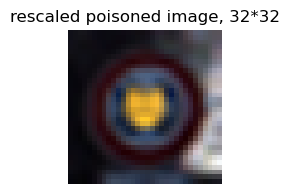

In [114]:
new_size = (32, 32)
image = Image.fromarray(poisoned_downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
rescaled_poisoned_array = np.array(rescaled_image)
print_image(rescaled_poisoned_array,"rescaled poisoned image, 32*32")

## Predictions

In [127]:
rescaled_poisoned_image = reprocess(rescaled_poisoned_array,source_record)
rescaled_original_image = reprocess(rescaled_image_array,source_record)
test_dataset = np.array([rescaled_poisoned_image, rescaled_original_image])

In [132]:
import tensorflow as tf
retrained_model_name = 'naive_attack_model.keras'
retrained_model = tf.keras.models.load_model(attack_folder+retrained_model_name)
predictions = retrained_model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [133]:
predicted_classes = np.argmax(predictions, axis=1)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Exemple {i+1}: Classe prédite = {predicted_class}")

Exemple 1: Classe prédite = [5.7000249e-09 9.9193829e-01 8.1358303e-07 4.1492951e-10 3.2478088e-08
 1.0325587e-06 5.7424687e-11 4.8219437e-09 9.8281570e-09 9.6787977e-12
 1.1722518e-11 7.2004230e-13 8.0597214e-03 4.7997783e-11 1.7675984e-09
 4.5849626e-11 4.0388879e-16 3.1655117e-13 4.3407504e-14 2.5216955e-14
 3.6401961e-13 1.5066016e-13 3.3848622e-11 5.6224154e-15 1.0667476e-14
 8.4441311e-14 6.5416984e-08 1.4451170e-17 2.5806223e-12 1.1533039e-10
 5.8466538e-15 1.9912227e-13 2.8259811e-10 7.0537937e-20 1.6361639e-14
 5.2801794e-15 2.9984695e-17 2.6097481e-19 1.5379551e-17 8.9964422e-19
 3.1386047e-19 9.1991186e-18 1.3780069e-13]
Exemple 2: Classe prédite = [5.7000249e-09 9.9193829e-01 8.1358303e-07 4.1492951e-10 3.2478088e-08
 1.0325587e-06 5.7424687e-11 4.8219437e-09 9.8281570e-09 9.6787977e-12
 1.1722518e-11 7.2004230e-13 8.0597214e-03 4.7997783e-11 1.7675984e-09
 4.5849626e-11 4.0388879e-16 3.1655117e-13 4.3407504e-14 2.5216955e-14
 3.6401961e-13 1.5066016e-13 3.3848622e-11 5.622